# Diffusion Models and the HuggingFace Diffusers Library

<span style="font-size: 15px;">

In the previous notebooks, we explored **Variational Autoencoders (VAEs)**, one of the foundational generative models. While VAEs introduced us to probabilistic latent spaces and the power of learned representations, they have a well-known limitation: they tend to produce blurry outputs and struggle with photorealistic, high-resolution image generation.

In this notebook, we introduce **Diffusion Models**, the generative architecture behind state-of-the-art systems like **Stable Diffusion**, **DALL-E 2**, **Midjourney**, and **Imagen**. These models have revolutionized image generation, enabling the creation of stunning, photorealistic images from text descriptions.

**What We'll Cover:**

1. **The Generative Modeling Landscape**: Where diffusion models fit among VAEs and GANs
2. **How Diffusion Models Work**: The forward (noising) and reverse (denoising) processes
3. **Why Diffusion Models Excel**: Quality, diversity, and the iterative refinement advantage
4. **Text-to-Image Generation**: How conditioning enables controllable generation
5. **The HuggingFace Ecosystem**: An overview of the tools we'll use
6. **Introduction to the Diffusers Library**: Our gateway to state-of-the-art diffusion models

</span>

## The Generative Modeling Trilemma

<span style="font-size: 15px;">

Before diving into diffusion models, it's helpful to understand where they fit in the broader landscape of generative models. There's a well-known **trilemma** in generative modeling, where models must trade off between three desirable properties:

| Property | Description |
|----------|-------------|
| **Quality** | How realistic and detailed are the generated outputs? |
| **Diversity** | Can the model generate a wide variety of different outputs? |
| **Speed** | How fast can the model generate new samples? |

**Where Different Models Fall:**

- **Variational Autoencoders (VAEs)**: Fast and diverse, but lower quality (blurry outputs)
- **Generative Adversarial Networks (GANs)**: High quality and fast, but can suffer from mode collapse (limited diversity)
- **Diffusion Models**: Exceptional quality and diversity, but slower due to iterative generation

The "impossible" center of the trilemma, achieving all three simultaneously, remains an active area of research. Recent advances like **Latent Diffusion Models** (used in Stable Diffusion) and distillation techniques are pushing closer to this goal.

**Why Diffusion Models Have Become Dominant:**

Despite their speed disadvantage, diffusion models have become the go-to choice for image generation because:
1. They scale incredibly well to high resolutions
2. They produce remarkably diverse outputs without mode collapse
3. Their iterative nature allows for controllable generation and guidance
4. They're more stable to train than GANs

</span>

## How Diffusion Models Work

<span style="font-size: 15px;">

The core idea behind diffusion models is elegantly simple:

> **If we can learn to gradually destroy data by adding noise, can we learn to reverse that process and create data from noise?**

This leads to a two-phase framework:

**The Forward Process (Encoding / Noising)**

Starting with a real image $x_0$, we progressively add Gaussian noise over $T$ timesteps:

$$
x_0 \xrightarrow{+\text{noise}} x_1 \xrightarrow{+\text{noise}} x_2 \xrightarrow{+\text{noise}} \cdots \xrightarrow{+\text{noise}} x_T \approx \mathcal{N}(0, I)
$$

By timestep $T$, the image has been completely corrupted into pure Gaussian noise. This process is **fixed** (not learned) and defined by a **noise schedule**.

**The Reverse Process (Decoding / Denoising)**

A neural network learns to reverse this process, progressively removing noise:

$$
x_T \xrightarrow{-\text{noise}} x_{T-1} \xrightarrow{-\text{noise}} \cdots \xrightarrow{-\text{noise}} x_1 \xrightarrow{-\text{noise}} x_0
$$

Starting from pure noise $x_T \sim \mathcal{N}(0, I)$, the model iteratively denoises to produce a clean image.

**Key Insight: Same Dimensionality Throughout**

Unlike VAEs where the latent space is compressed ($D_z \ll D_x$), in diffusion models:

$$
\text{dim}(x_0) = \text{dim}(x_1) = \cdots = \text{dim}(x_T)
$$

The "latent space" is simply **noised image space** of the same dimension as the output.

</span>

## Mathematical Framework

<span style="font-size: 15px;">

**The Forward Process $q(x_t | x_{t-1})$**

The forward process is a **Markov chain** that gradually adds Gaussian noise according to a variance schedule $\beta_1, \beta_2, \ldots, \beta_T$:

$$
q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} \, x_{t-1}, \beta_t I)
$$

This means at each step:
- We scale down the previous image by $\sqrt{1 - \beta_t}$
- We add Gaussian noise with variance $\beta_t$

**Useful Property**: We can sample $x_t$ directly from $x_0$ without iterating through all steps:

$$
q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} \, x_0, (1 - \bar{\alpha}_t) I)
$$

where $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$.

This can be written as:
$$
x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

</span>

<span style="font-size: 15px;">

**The Reverse Process $p_\theta(x_{t-1} | x_t)$**

The reverse process is what we **learn**. We train a neural network to approximate:

$$
p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
$$

The network predicts the mean $\mu_\theta$ (and optionally variance $\Sigma_\theta$) of the denoised image at each step.

**In Practice**: Rather than predicting $\mu_\theta$ directly, most implementations train the network to predict the **noise** $\epsilon_\theta(x_t, t)$ that was added. The mean can then be computed as:

$$
\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right)
$$

**Training Objective**

The model is trained to predict the noise that was added, using a simple MSE loss:

$$
\mathcal{L} = \mathbb{E}_{t, x_0, \epsilon} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
$$

where:
- $t \sim \text{Uniform}(1, T)$ is a random timestep
- $\epsilon \sim \mathcal{N}(0, I)$ is the noise added to create $x_t$ from $x_0$
- $\epsilon_\theta(x_t, t)$ is the network's prediction of that noise

</span>

### Connection to Variational Autoencoders

<span style="font-size: 15px;">

Diffusion models can actually be understood through the lens of VAEs:

| Aspect | VAE | Diffusion Model |
|--------|-----|------------------|
| **Encoder** | $q_\phi(z|x)$ (learned) | $q(x_t|x_0)$ (fixed, adds noise) |
| **Latent Space** | Low-dimensional $z$ | Same-dimensional noised images $x_t$ |
| **Decoder** | $p_\theta(x|z)$ (one step) | $p_\theta(x_{t-1}|x_t)$ ($T$ steps) |
| **Training** | ELBO maximization | Simplified noise prediction |

Each transition $x_t \to x_{t-1}$ can be thought of as a mini-VAE, and the full diffusion model chains $T$ of these together.

The key difference is that diffusion models:
1. Use a **fixed** encoder (just add noise according to a schedule)
2. Learn a **sequence** of small denoising steps rather than one big decoding step
3. Keep the **full dimensionality** throughout the process

</span>

## The Power of Iterative Denoising

<span style="font-size: 15px;">

One of the most powerful features of diffusion models is their **iterative nature**. Unlike VAEs and GANs that generate images in a single forward pass, diffusion models refine their output over many steps.

**Adjustable Quality-Speed Tradeoff**

The number of denoising steps $T$ is adjustable at inference time:

| Fewer Steps | More Steps |
|-------------|------------|
| Faster generation | Slower generation |
| Lower quality | Higher quality |
| Good for previews | Good for final outputs |

This gives users control over the quality-speed tradeoff based on their needs.

**Generation Process**

To generate a new image:

1. **Sample pure noise**: $x_T \sim \mathcal{N}(0, I)$
2. **Iteratively denoise**: For $t = T, T-1, \ldots, 1$:
   - Predict noise: $\hat{\epsilon} = \epsilon_\theta(x_t, t)$
   - Compute $x_{t-1}$ using the predicted noise
3. **Output**: $x_0$ is the final generated image

This is analogous to the VAE generation process:
- **VAE**: Sample $z \sim \mathcal{N}(0, I)$, decode in one step
- **Diffusion**: Sample $x_T \sim \mathcal{N}(0, I)$, decode in $T$ steps

</span>

## Conditional Generation: Text-to-Image

<span style="font-size: 15px;">

The iterative nature of diffusion models makes them exceptionally well-suited for **conditional generation**, where we want to guide the output based on some input (like a text prompt).

**How Text-to-Image Works**

1. **Encode the text prompt**: A text encoder (typically a Transformer) converts the prompt into an embedding vector
   
   $$\text{"A golden retriever playing in the snow"} \xrightarrow{\text{Transformer}} c_{\text{text}}$$

2. **Sample noise**: Start with random Gaussian noise $x_T \sim \mathcal{N}(0, I)$

3. **Conditioned denoising**: The denoising network takes both the noisy image AND the text embedding:
   
   $$\epsilon_\theta(x_t, t, c_{\text{text}})$$
   
   The text conditioning guides each denoising step toward images that match the description.

4. **Output**: After $T$ steps, we get an image matching the text prompt

**Why This Works So Well**

- **Gradual refinement**: The model can make small adjustments at each step to better match the conditioning
- **Flexibility**: The same architecture works for text, images, class labels, or any other conditioning
- **Guidance scales**: We can control how strongly the output follows the conditioning

**Classifier-Free Guidance**

Modern text-to-image models use **classifier-free guidance** to strengthen the effect of the text prompt:

$$
\hat{\epsilon} = \epsilon_\theta(x_t, t, \emptyset) + s \cdot (\epsilon_\theta(x_t, t, c) - \epsilon_\theta(x_t, t, \emptyset))
$$

where $s > 1$ is the guidance scale. Higher values produce images that more strongly match the prompt (but may sacrifice diversity).

</span>

## The HuggingFace Ecosystem

<span style="font-size: 15px;">

Before we start coding, let's understand the tools we'll be using. **HuggingFace** has become the central hub for open-source machine learning, providing:

**Core Libraries**

| Library | Purpose | We'll Use It For |
|---------|---------|------------------|
| **🤗 Transformers** | NLP and beyond | Text encoders for conditioning |
| **🧨 Diffusers** | Diffusion models | Image generation pipelines |
| **📦 Datasets** | Data loading | Training data (if fine-tuning) |
| **🚀 Accelerate** | Distributed training | Multi-GPU training |

**The Diffusers Library**

The `diffusers` library is our main focus. It provides:

1. **Pipelines**: High-level APIs for common tasks (text-to-image, image-to-image, inpainting)
2. **Models**: Pre-trained UNet, VAE, and text encoder components
3. **Schedulers**: Different noise schedules and sampling algorithms
4. **Utilities**: Image processing, model loading, and more

**Why HuggingFace?**

- **Unified API**: Consistent interface across different models
- **Model Hub**: Thousands of pre-trained models ready to use
- **Active Community**: Regular updates, tutorials, and support
- **Interoperability**: Libraries work seamlessly together

**Documentation Resources**

- **Diffusers Docs**: [huggingface.co/docs/diffusers](https://huggingface.co/docs/diffusers)
- **Model Hub**: [huggingface.co/models](https://huggingface.co/models)
- **Tutorials**: [huggingface.co/docs/diffusers/tutorials](https://huggingface.co/docs/diffusers/tutorials)

</span>

## Introduction to Diffusers

<span style="font-size: 15px;">

The `diffusers` library makes it remarkably easy to use state-of-the-art diffusion models. Let's start with the basics.

**Installation**

```bash
pip install diffusers transformers accelerate torch
```

**Key Concepts**

**1. Pipelines**: End-to-end workflows that combine all components
```python
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
image = pipe("a photo of a cat").images[0]
```

**2. Schedulers**: Control the noise schedule and sampling process
```python
from diffusers import DDPMScheduler, DDIMScheduler, EulerScheduler
```

**3. Models**: The neural network components
```python
from diffusers import UNet2DConditionModel, AutoencoderKL
```

**Common Pipelines**

| Pipeline | Task | Input → Output |
|----------|------|----------------|
| `StableDiffusionPipeline` | Text-to-Image | Text → Image |
| `StableDiffusionImg2ImgPipeline` | Image-to-Image | Image + Text → Image |
| `StableDiffusionInpaintPipeline` | Inpainting | Image + Mask + Text → Image |
| `StableDiffusionUpscalePipeline` | Super-resolution | Low-res → High-res |

</span>

## Setup and Imports

In [8]:
# Core imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# HuggingFace imports
from diffusers import StableDiffusionPipeline, DDPMScheduler
from diffusers import DiffusionPipeline

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Check device
device = (
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)
print(f"Using device: {device}")

# Set seed for reproducibility
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed(42)

Using device: mps


## First Diffusion Generation

<span style="font-size: 15px;">

Let's generate our first image using Stable Diffusion. We'll start with a simple, clear example.

**Note**: Running Stable Diffusion requires a GPU with at least 8GB VRAM. If you're on CPU or have limited memory, we'll also show alternatives.

</span>

In [14]:
# Load the Stable Diffusion pipeline from local files
# Using Segmind's Small SD (~500MB) - a distilled, faster version

model_id = "data/small-sd"

# Load with float16 for memory efficiency (GPU only)
if device == 'cuda':
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        safety_checker=None  # Disable for educational purposes
    )
else:
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        safety_checker=None
    )

pipe = pipe.to(device)

print(f"Pipeline loaded on {device}")
print(f"Pipeline components: {list(pipe.components.keys())}")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch data/small-sd/vae: Error no file named diffusion_pytorch_model.safetensors found in directory data/small-sd/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch data/small-sd/unet: Error no file named diffusion_pytorch_model.safetensors found in directory data/small-sd/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Pipeline loaded on mps
Pipeline components: ['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


  0%|          | 0/50 [00:00<?, ?it/s]

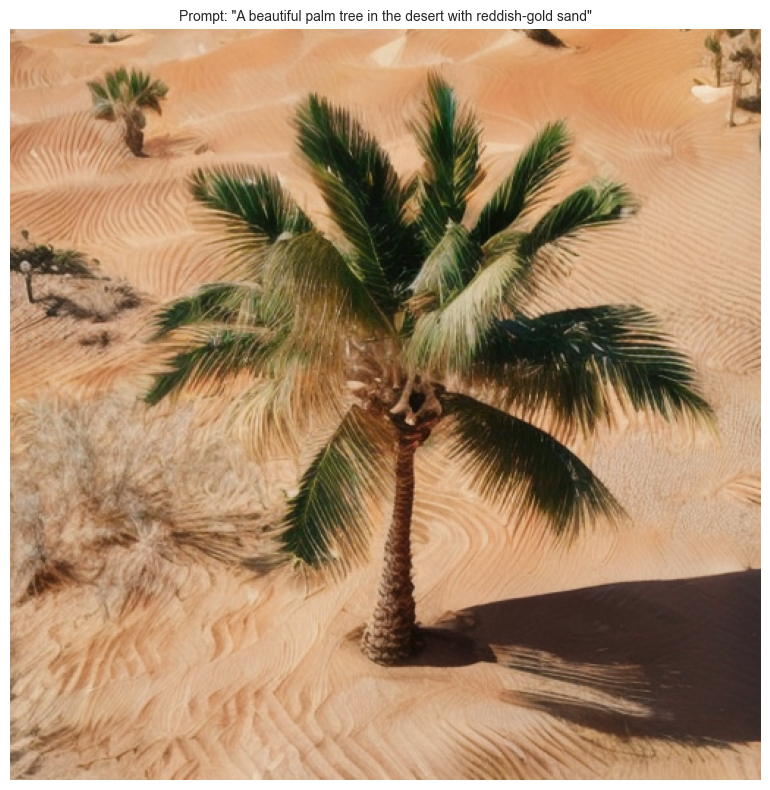

In [19]:
# Generate an image!
prompt = "A beautiful palm tree in the desert with reddish-gold sand"

# Set a seed for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Generate
with torch.no_grad():
    result = pipe(
        prompt,
        num_inference_steps=50,  # Number of denoising steps
        guidance_scale=7.5,       # How strongly to follow the prompt
        generator=generator
    )

image = result.images[0]

# Display
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f'Prompt: "{prompt}"', fontsize=10, wrap=True)
plt.axis('off')
plt.tight_layout()
plt.show()

## Understanding the Parameters

<span style="font-size: 15px;">

Let's understand the key parameters we used:

**`num_inference_steps`**

The number of denoising steps. More steps = higher quality but slower.

| Steps | Quality | Speed | Use Case |
|-------|---------|-------|----------|
| 20 | Low-Medium | Fast | Quick previews |
| 50 | Good | Medium | Default, balanced |
| 100+ | High | Slow | Final outputs |

**`guidance_scale` (Classifier-Free Guidance)**

How strongly the image should match the prompt.

| Scale | Effect |
|-------|--------|
| 1.0 | No guidance (random, diverse) |
| 7.5 | Default, good balance |
| 15+ | Very strong adherence (may look artificial) |

**`generator`**

Random seed for reproducibility. Same seed + same prompt = same image.

</span>

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

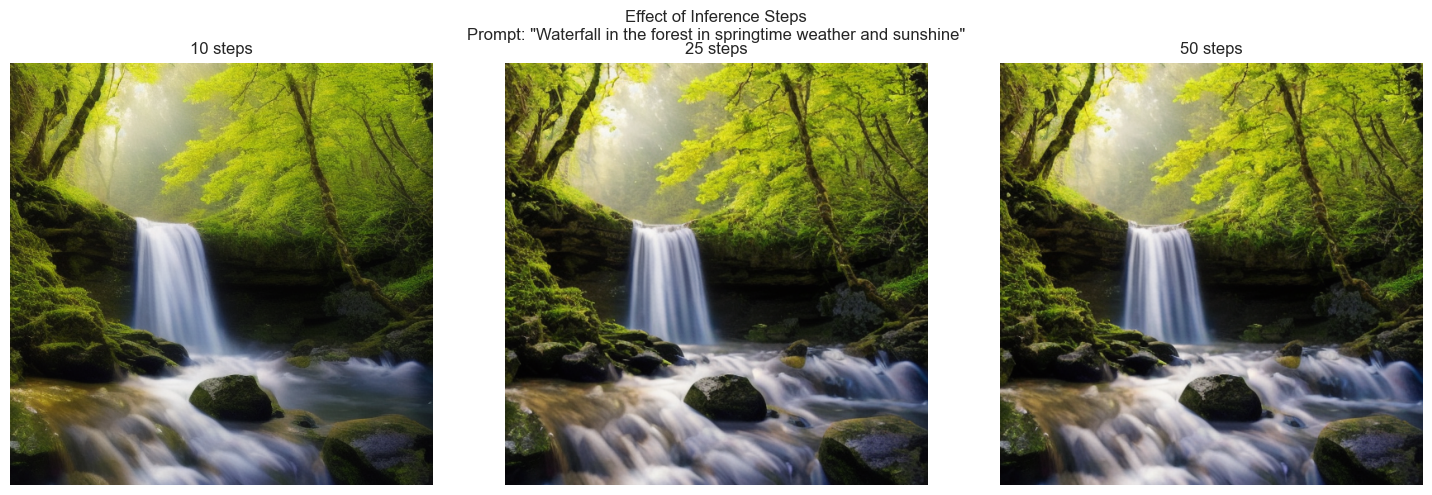

In [24]:
# Compare different numbers of inference steps
prompt = "Waterfall in the forest in springtime weather and sunshine"

step_counts = [10, 25, 50]
images = []

for steps in step_counts:
    generator = torch.Generator(device=device).manual_seed(42)  # Same seed
    with torch.no_grad():
        result = pipe(prompt, num_inference_steps=steps, guidance_scale=7.5, generator=generator)
    images.append(result.images[0])

# Display comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img, steps in zip(axes, images, step_counts):
    ax.imshow(img)
    ax.set_title(f'{steps} steps')
    ax.axis('off')

plt.suptitle(f'Effect of Inference Steps\nPrompt: "{prompt}"', fontsize=12)
plt.tight_layout()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

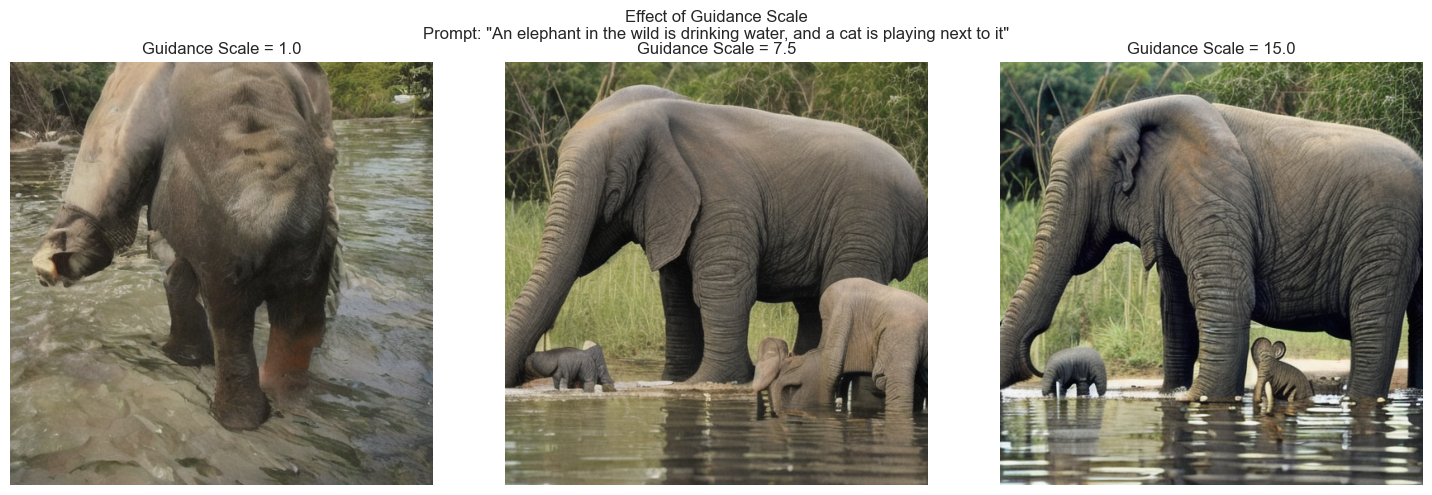

In [23]:
# Compare different guidance scales
prompt = "An elephant in the wild is drinking water, and a cat is playing next to it"

guidance_scales = [1.0, 7.5, 15.0]
images = []

for scale in guidance_scales:
    generator = torch.Generator(device=device).manual_seed(42)  # Same seed
    with torch.no_grad():
        result = pipe(prompt, num_inference_steps=50, guidance_scale=scale, generator=generator)
    images.append(result.images[0])

# Display comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img, scale in zip(axes, images, guidance_scales):
    ax.imshow(img)
    ax.set_title(f'Guidance Scale = {scale}')
    ax.axis('off')

plt.suptitle(f'Effect of Guidance Scale\nPrompt: "{prompt}"', fontsize=12)
plt.tight_layout()
plt.show()

## Summary

<span style="font-size: 15px;">

**Key Takeaways**

**1. Diffusion Models** learn to generate images by:
   - **Forward process**: Gradually adding noise to images (fixed, not learned)
   - **Reverse process**: Learning to remove noise step by step (trained)

**2. Mathematical Foundation**:
   - Forward: $q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t I)$
   - Reverse: $p_\theta(x_{t-1} | x_t)$ learned by predicting the noise $\epsilon_\theta(x_t, t)$
   - Training: $\mathcal{L} = \|\epsilon - \epsilon_\theta(x_t, t)\|^2$

**3. Advantages over VAEs**:
   - Higher quality outputs
   - Better diversity
   - Adjustable quality-speed tradeoff
   - Natural support for conditioning

**4. Text-to-Image** works by:
   - Encoding text with a Transformer
   - Conditioning the denoising process on the text embedding
   - Using classifier-free guidance to strengthen prompt adherence

**5. HuggingFace Diffusers** provides:
   - High-level pipelines for common tasks
   - Pre-trained state-of-the-art models
   - Modular components for customization

</span>

## Quick Reference

| Concept | Formula / Code |
|---------|----------------|
| Forward process | $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$ |
| Training objective | $\mathcal{L} = \|\epsilon - \epsilon_\theta(x_t, t)\|^2$ |
| Load pipeline | `pipe = StableDiffusionPipeline.from_pretrained(model_id)` |
| Generate image | `pipe(prompt, num_inference_steps=50, guidance_scale=7.5)` |
| Reproducibility | `generator = torch.Generator(device).manual_seed(42)` |